In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import json
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

RANDOM_STATE = 1048576
# Device configuration (use GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Import

In [2]:
def import_data(root: str, verbose: bool=False) -> datasets.ImageFolder:
    # Load the entire dataset from a single directory
    full_dataset = datasets.ImageFolder(root=root, transform=None)

    # Print the total number of images and class names if verbose=True
    if verbose:
        print(f"Total number of images: {len(full_dataset)}")
        print(f"Number of classes: {len(full_dataset.classes)}")
        print(f"First 5 Classes: {full_dataset.classes[:5]}")
    return full_dataset

full_dataset = import_data('dataset', verbose=True)
class_to_idx = full_dataset.class_to_idx
with open('class_to_idx.json', 'w') as f:
    json.dump(class_to_idx, f)

Total number of images: 18875
Number of classes: 165
First 5 Classes: ['base1', 'base2', 'base3', 'base4', 'base5']


# Image Transformation

In [5]:
from torchvision.transforms import RandomApply, RandomAffine, RandomPerspective, RandomErasing, GaussianBlur, ColorJitter

# Define a set of augmentations for training
train_transform = transforms.Compose([
    transforms.Resize((342, 245)),  # Resize to a fixed size (adjust based on your model input)
    RandomApply([ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),  # Random lighting variations
    RandomApply([GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.3),  # Simulate out-of-focus
    RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Simulate different angles with rotation and scaling
    RandomPerspective(distortion_scale=0.2, p=0.3),  # Simulate perspective changes
    # transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally, normally does not help with this type of classification
    transforms.ToTensor(),  # Convert image to tensor
    RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Simulate partial occlusion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats (adjust if needed)
])

# Define a simpler transform for validation/test (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((342, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Train-val-test Split

In [6]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


In [7]:
def train_test_split(data: datasets.ImageFolder, val_ratio: float=0.1, test_ratio: float=0.1, batch_size: int=32, train_transform: transforms=None, val_transform: transforms=None, random_state=RANDOM_STATE, verbose: bool=False) -> tuple:
    torch.manual_seed(random_state)

    test_size = int(test_ratio * len(data))
    val_size = int(val_ratio * len(data))
    train_size = len(data) - test_size - val_size

    train_subset, val_subset, test_subset = random_split(data, [train_size, val_size, test_size])

    # Wrap with independent transforms
    train_dataset = TransformSubset(train_subset, transform=train_transform)
    val_dataset = TransformSubset(val_subset, transform=val_transform)
    test_dataset = TransformSubset(test_subset, transform=val_transform)

    if verbose:
        print(f"Training set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
        print(f"Test set size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = train_test_split(full_dataset, batch_size=32, train_transform=train_transform, val_transform=val_transform, random_state=RANDOM_STATE, verbose=True)

Training set size: 15101
Validation set size: 1887
Test set size: 1887


# Visualize the transformations (only works when num_workers=0)

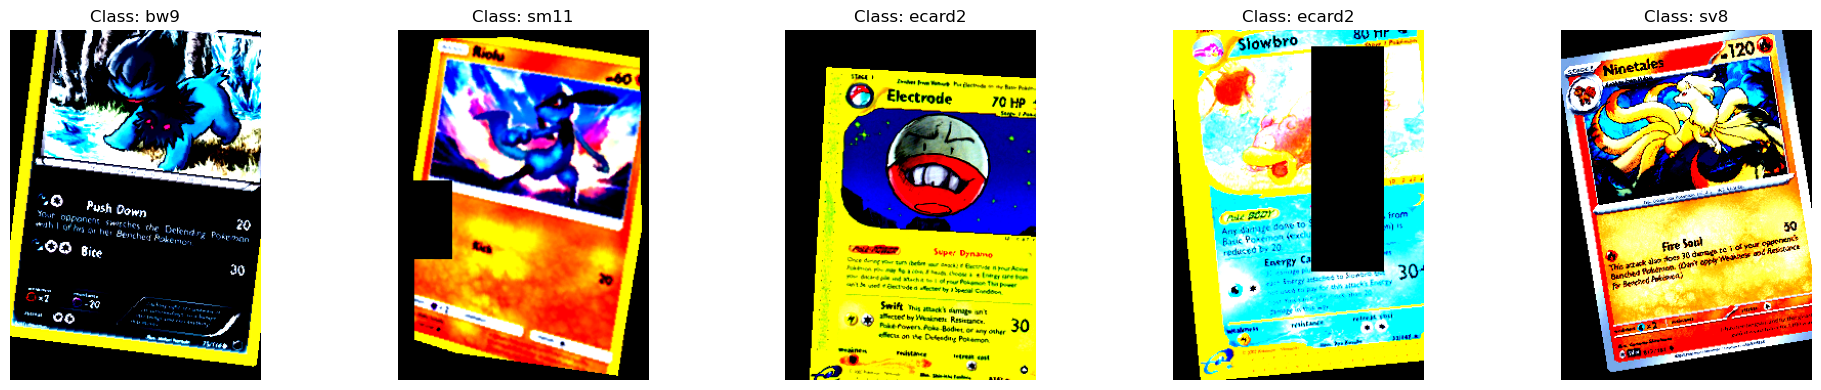

In [8]:
import matplotlib.pyplot as plt

def visualize_augmentations(data_loader, num_samples=5, save_path=None):
    # Grab one batch
    images, labels = next(iter(data_loader))
    
    # Ensure we don't exceed batch size
    num_samples = min(num_samples, len(images))

    class_names = data_loader.dataset.subset.dataset.classes

    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Clip to [0, 1] for display
        label = labels[i].item()
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_augmentations(train_loader, num_samples=5)

# Model Loading (ResNet 18)

In [9]:
class ResNet18WithDropout(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

base = models.resnet18(pretrained=True)
model = ResNet18WithDropout(base, num_classes=165)


c:\Users\User\miniconda3\envs\card-reader\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\card-reader\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
num_classes = 165
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [11]:
# # Optional: Freeze earlier layers (to speed up training if data is small)
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.fc.parameters():
#     param.requires_grad = True

# Model Training

In [12]:
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, os.path.join(checkpoint_dir, filename))

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [14]:
# Initialize the model, loss function, and optimizer
num_classes = len(full_dataset.classes)  # Number of classes based on dataset
model = model.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # For classification
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6
)


Using BatchNorm needs to tune up the learning rate

## Load checkpoints

In [15]:
# Define where your checkpoint is saved
checkpoint_path = "./checkpoints/checkpoint.pth"
check_checkpoint = False  # Set to False if you want to start from scratch

# Load checkpoint
if os.path.exists(checkpoint_path) and check_checkpoint:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict']) if 'scheduler_state_dict' in checkpoint else None
    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with val loss {best_loss:.4f}")
else:
    start_epoch = 0
    best_loss = float('inf')
    print("No checkpoint found. Starting from scratch.")

No checkpoint found. Starting from scratch.


c:\Users\User\miniconda3\envs\card-reader\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


New best model saved at epoch 1 with val loss 3.3732
Epoch [1/50]
Train Loss: 4.1499, Train Accuracy: 8.60%
Val Loss: 3.3732, Val Accuracy: 13.94%
--------------------------------------------------
New best model saved at epoch 2 with val loss 3.1569
Epoch [2/50]
Train Loss: 3.3565, Train Accuracy: 15.67%
Val Loss: 3.1569, Val Accuracy: 19.08%
--------------------------------------------------
New best model saved at epoch 3 with val loss 2.9770
Epoch [3/50]
Train Loss: 3.1282, Train Accuracy: 20.50%
Val Loss: 2.9770, Val Accuracy: 22.58%
--------------------------------------------------
New best model saved at epoch 4 with val loss 2.7993
Epoch [4/50]
Train Loss: 2.9382, Train Accuracy: 25.35%
Val Loss: 2.7993, Val Accuracy: 28.56%
--------------------------------------------------
New best model saved at epoch 5 with val loss 2.6923
Epoch [5/50]
Train Loss: 2.7872, Train Accuracy: 30.14%
Val Loss: 2.6923, Val Accuracy: 31.16%
--------------------------------------------------
New be

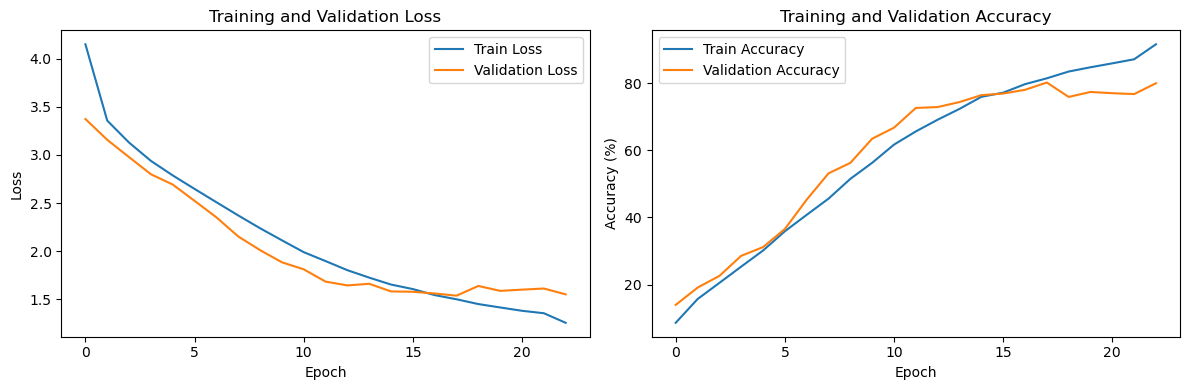

Test Loss: 1.5710, Test Accuracy: 79.39%


In [16]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=20, early_stopping=5, debug=False):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_monitor = EarlyStopping(patience=early_stopping)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if debug:
                if batch_count < 10 or (batch_count % 10 == 0 and batch_count <= 100) or (batch_count % 100 == 0):
                    print(f"Batch {batch_count} / {len(train_loader)}, Epoch {epoch+1}")
                    # Get current LR
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Current LR: {current_lr}")
                batch_count += 1
            optimizer.zero_grad()
            outputs= model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # if scheduler is not None:
            #     scheduler.step() # Update learning rate if using OneCycleLR scheduler
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if scheduler is not None:
            scheduler.step(val_loss)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Save checkpoint
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)

        # Save best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print(f"New best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')
        print('-' * 50)

        # Check for early stopping
        early_stopping_monitor(epoch_val_loss)
        if early_stopping_monitor.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs, debug=False
)

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

evaluate_model(model, test_loader, criterion)

# Save the model (optional)
torch.save(model.state_dict(), 'resnet18_v1.pth')

1st run: Super overfit (95% vs 55 %)\
2nd run: Label_smoothing + weight decay + ReduceLROnPlateau -> similar overfit (95% vs 55 %)\
3rd run: Added dropout -> better, still overfit (95% vs 72 %)\
4th run: Added early stopping, best result at 81.49% vs 80.23%

# Model Analysis

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'all_preds' and 'all_labels' are your full val predictions and targets
cm = confusion_matrix(val_loader, all_preds)
sns.heatmap(cm, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.show()


NameError: name 'all_preds' is not defined

In [ ]:
# Initialize the model and load trained weights (if available)
num_classes = len(full_dataset.classes)
model = CardAttributeCNN(num_classes).to(device)
model_path = 'base_model_v5.pth'  # Adjust to your saved model path
# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path))
#     print(f"Loaded trained model from {model_path}")
model.eval()  # Set to evaluation mode

# Select a sample image (e.g., first image from the dataset)
sample_image, sample_label = full_dataset[np.random.randint(0, len(full_dataset))]  # You can change the index
sample_image = transforms.Compose([transforms.ToTensor()])(sample_image)
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Reverse normalization for visualizing the input image
unnorm_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
input_img = unnorm_transform(sample_image.squeeze(0).cpu()).permute(1, 2, 0).numpy()
input_img = input_img.clip(0, 1)

# Forward pass to get activations
with torch.no_grad():
    _, activations = model(sample_image, return_activations=True)

# Function to visualize feature maps
def visualize_feature_maps(activations, layer_names, num_channels_to_show=8):
    for layer_idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        activation = activation.squeeze(0).cpu().numpy()  # Remove batch dimension, move to CPU
        num_channels = activation.shape[0]  # Number of channels in this layer
        channels_to_show = min(num_channels, num_channels_to_show)  # Limit to num_channels_to_show
        
        # Create a grid of subplots for this layer
        fig, axes = plt.subplots(1, channels_to_show, figsize=(channels_to_show * 2, 2))
        if channels_to_show == 1:
            axes = [axes]  # Ensure axes is iterable if only one channel
        
        for ch in range(channels_to_show):
            # Plot the feature map for this channel
            axes[ch].imshow(activation[ch], cmap='viridis')  # Use 'viridis' or 'gray' colormap
            axes[ch].axis('off')
            if ch == 0:
                axes[ch].set_title(f'{layer_name}\nChannel {ch}')
            else:
                axes[ch].set_title(f'Channel {ch}')
        plt.suptitle(f'Feature Maps for {layer_name} (First {channels_to_show} Channels)')
        plt.tight_layout()
        plt.show()

# Visualize the input image
plt.figure(figsize=(5, 5))
plt.imshow(input_img)
plt.title(f'Input Image (Class: {full_dataset.classes[sample_label]})')
plt.axis('off')
plt.show()

# Visualize feature maps for each ConvBlock
layer_names = ['Block 1 (16 channels)', 'Block 2 (32 channels)', 'Block 3 (64 channels)']
visualize_feature_maps(activations, layer_names, num_channels_to_show=8)

NameError: name 'CardAttributeCNN' is not defined

1. BATCH NORM
2. Use GenAI to give more transformations to the images to enrich the dataset
3. Can use Hugging Face pytorch-image-model (TIM)